# Detailed Usage

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import imageio
import sys
import io
import matplotlib.pyplot as plt
sys.path.append("../radialmri/")
from simulation_and_reconstruction import *

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Load and Preprocess a Short Vedio for Simulation

In [2]:
#imageio.plugins.ffmpeg.download() #if this is neeeded for the first time

with open("../sample/51925-52494.mkv", "rb") as file:
    content = file.read()
    
vid = imageio.get_reader(io.BytesIO(content),  'ffmpeg')

metadata = vid.get_meta_data()                                                             

print(metadata)

len(vid)/metadata['fps']

{'plugin': 'ffmpeg', 'nframes': 570, 'ffmpeg_version': 'N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/ built with gcc 5.4.1 (Debian 5.4.1-8) 20170304', 'fps': 29.97, 'source_size': (3840, 2160), 'size': (3840, 2160), 'duration': 19.02}


19.01901901901902

In [3]:
framelist = []
for num, image in enumerate(vid.iter_data()): 
    framelist.append(image)
    #print(image.shape)
    #print(image.mean())
print(len(framelist))

570


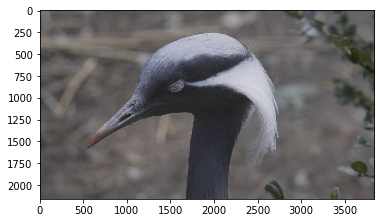

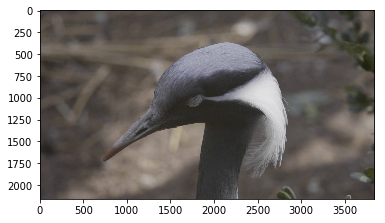

In [4]:
plt.imshow(framelist[150])
plt.show()

plt.imshow(framelist[400])
plt.show()

(25, 2160, 2160)


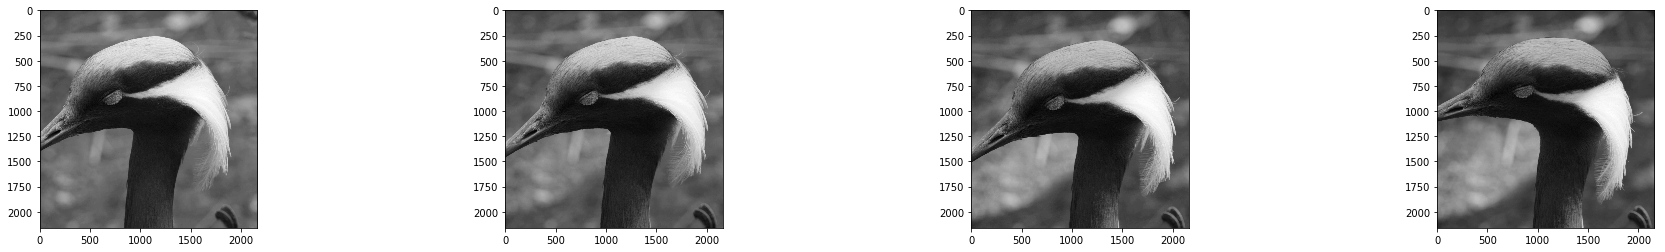

In [5]:
selected = []
for i in range(150, 400, 10):
    selected.append(np.sum(framelist[i], axis= 2) [:, (3840 -2160) // 2 : (3840 -2160) // 2 + 2160 ]/ (3.0 * 255.0))

varray = np.array(selected)
#varray = np.transpose(varray, (2, 0, 1)) # [frame, x, y]

print(varray.shape)

#Nte: this plotcoil() function plots a series of images, the temporal image frames here.  
#Not necessarily the coil images but based on what is defined in the first dimension of the input array. 
plotcoil(varray[::6], n = 4)

## Notice and compare the follow details in the ground truth and reconstructed image series.
## 1. The subtle change of the contrast on the top of the bird's head.
## 2. The more obvious change of constrast in the background

## Simulate Coil Sensitivities Maps

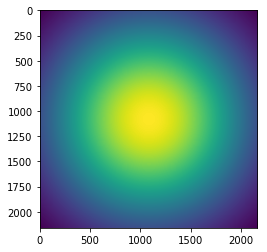

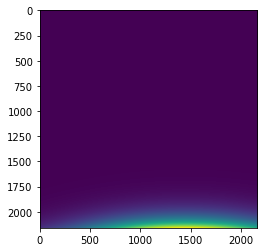

-2.226433342743504 1.5309765298298963
-0.8581773853503973 0.5358564914728037
2.3356774790426655 0.03233715516850744
-1.1014301519500507 -1.5483941547020383
-0.08535514074173545 -2.2356482708957715
-1.3747632568988661 2.0931330106236334
1.246680741219163 2.39627152472812
0.5585588288919703 0.20629340984881583
-0.7473551164949734 -1.423502146903518
1.8089677401687556 2.3669998822708314
-0.6114275925462653 2.3464092192757615
-0.017748191976167504 0.5810137149960255
-2.5337262046693545 -0.7795272016713231
-1.8665636401290442 -0.18356384989761088
0.35837849106563446 2.151015231988641
-2.1908170374363625 0.06649426468970931


In [6]:
def coil_smap_sim(h, w, x0 = 0, y0 = 0):
    #https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
    # Initializing value of x-axis and y-axis
    # in the range -2 to +2
    x, y = np.meshgrid(np.linspace(-3, 3, h), np.linspace(-3, 3, w))
    dst = np.sqrt(x**2 + y**2)

    # Intializing sigma and muu
    sigma_x, sigma_y = 2.0, 2.0 * h / w

    # Calculating Gaussian array
    gauss = np.exp(-( (x - x0)**2 / ( 2.0 * sigma_x**2 ) \
                    + (y - y0)**2 / ( 2.0 * sigma_y**2 ) ) )
    
    return gauss

def multi_coil_smap_sim(h, w, ncoil = 16):
    res = []
    for i in range(ncoil):
        x0, y0 = np.random.uniform(-3, 3, size = 2)
        print(x0, y0)
        res.append(coil_smap_sim(h, w, x0, y0))
        
    return np.array(res)

gauss = coil_smap_sim(2160, 2160)

plt.imshow(gauss)
plt.show()

gauss = coil_smap_sim(2160, 2160, 1, 16)

plt.imshow(gauss)
plt.show()

smap = multi_coil_smap_sim(2160, 2160, ncoil = 16)

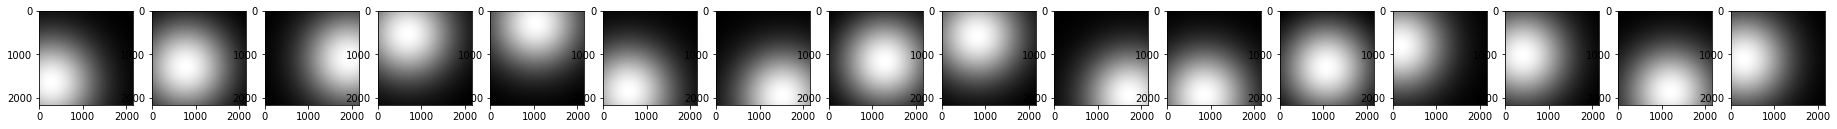

(16, 2160, 2160) (25, 2160, 2160)


In [7]:
plotcoil(x = smap, n = 16)
print(smap.shape, varray.shape)

(2160, 2160)


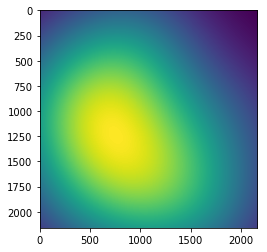

In [8]:
coilintensity = coil_combine(coilimages = smap, ss = smap, coild = 0)
print(coilintensity.shape)
plt.imshow(coilintensity)
plt.show()

smap_ic = smap / coilintensity
intensity_afteric = coil_combine(coilimages = smap_ic, ss = smap_ic, coild = 0)
print(intensity_afteric.shape)
plt.imshow(intensity_afteric)
plt.show()

In [10]:
target = np.repeat(np.expand_dims(varray, axis=0), repeats=2, axis= 0).swapaxes(0, 1) / np.sqrt(2.0)
target[:, 1] *= 1/2 #introduce a constant phase
print(target.shape)

smap = np.expand_dims(np.repeat(np.expand_dims(smap, axis=0), repeats=2, axis= 0).swapaxes(0, 1), 0) / np.sqrt(2.0)
smap_ic = np.expand_dims(np.repeat(np.expand_dims(smap_ic, axis=0), repeats=2, axis= 0).swapaxes(0, 1), 0) / np.sqrt(2.0)

print(smap.shape)
print(smap_ic.shape)

(25, 2, 2160, 2160)
(1, 16, 2, 2160, 2160)
(1, 16, 2, 2160, 2160)


## Fully Sampled Cartesian $k$-space Simulation

In [12]:
model = CartesianModel()
kspace = model.forward(x = torch.tensor(target[:2], dtype = torch.float32).to(device), 
                       coil_sensitivities= (torch.tensor(smap.repeat(2, 0), dtype = torch.float32).to(device)).permute(1, 0, 2, 3, 4))

In [13]:
print(kspace.shape)
recon = model.backward(y = kspace, coil_sensitivities= (torch.tensor(smap.repeat(2, 0), dtype = torch.float32).to(device)).permute(1, 0, 2, 3, 4))

torch.Size([16, 2, 2160, 2160, 2])
y.shape torch.Size([16, 2, 2160, 2160, 2])


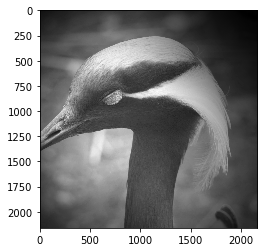

In [16]:
recon.shape
plt.imshow(recon[0, 0, 0, :, :].cpu(), cmap = 'gray')
plt.show()

## Radial $k$-space Simulation

torch.Size([9, 1, 2, 13440])
torch.Size([9, 16, 2, 13440])
torch.Size([9, 2, 540, 540])


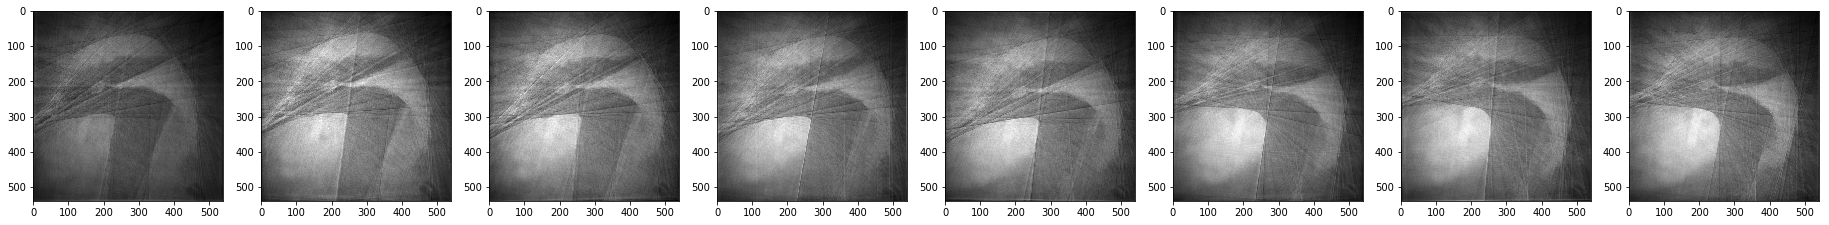

In [40]:
#down-sample the image by 4 in the image domain, and also by 3 in the temporal domain due to GPU memory limitation
#print(target[:, :, ::4, ::4].shape, smap[:,:,:,::4,::4].shape)

device = torch.device("cuda")
#device = torch.device("cpu")
kspace, recon, traj, dcomp = RadialSimulation(target= torch.tensor(target[::3, :, ::4, ::4], dtype = torch.float32).to(device), 
                                                 spokespertime= 21, nt= 9, nc = 1, spokelength= 640, 
                                                 smap= torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
                                                 grid_size= (1080, 1080), im_size= (540, 540))

plotcoil(torch.sqrt(recon[:, 0]**2 + recon[:, 1]**2).cpu())

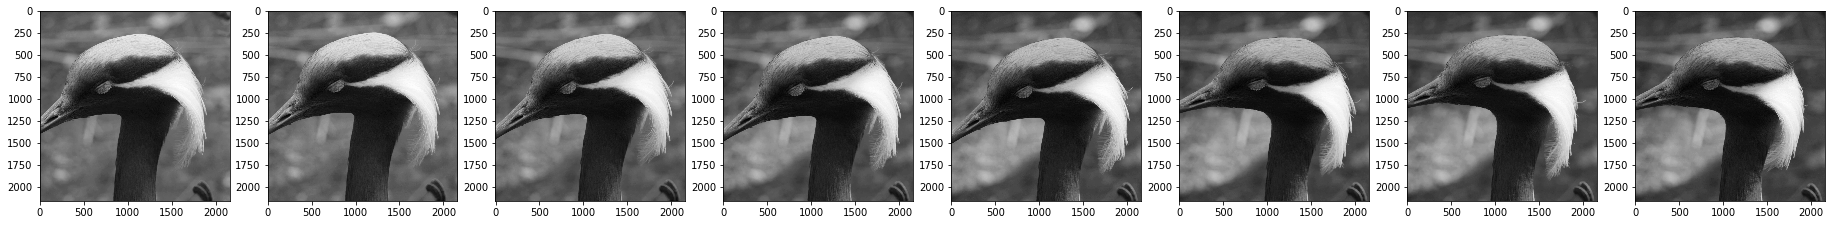

In [21]:
plotcoil(varray[::3])

In [47]:
grid_size = (1080, 1080)
im_size = (540, 540)

Rdmodel = RadialModel(grid_size=grid_size, im_size= im_size).\
        to(device, dtype)

x_adjn = Rdmodel.adjoint(y = (torch.tensor(kspace) * torch.sqrt(dcomp)).to(device, dtype),
                         k = torch.tensor(traj).to(device, dtype),
                         coil_sensitivities= torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device, dtype),
                         #coil_sensitivities= smap_nm.to(device, dtype),
                         w = torch.sqrt(dcomp).to(device, dtype))

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


## Radial Reconstruction using [iGRASP](https://pubmed.ncbi.nlm.nih.gov/24142845/)* (Conjugate Gradient with Regularization)

\* Feng L, Grimm R, Block KT, Chandarana H, Kim S, Xu J, Axel L, Sodickson DK, Otazo R. Golden-angle radial sparse parallel MRI: combination of compressed sensing, parallel imaging, and golden-angle radial sampling for fast and flexible dynamic volumetric MRI. Magn Reson Med. 2014 Sep;72(3):707-17. doi: 10.1002/mrm.24980. Epub 2013 Oct 18. PMID: 24142845; PMCID: PMC3991777.

In [48]:
x_adjn_np = torch2numpy(x_adjn, complexdim=1)
lambda1 = 2.5e-2 * max(np.abs(x_adjn_np.flatten()))
print(lambda1)

0.005746093019843102


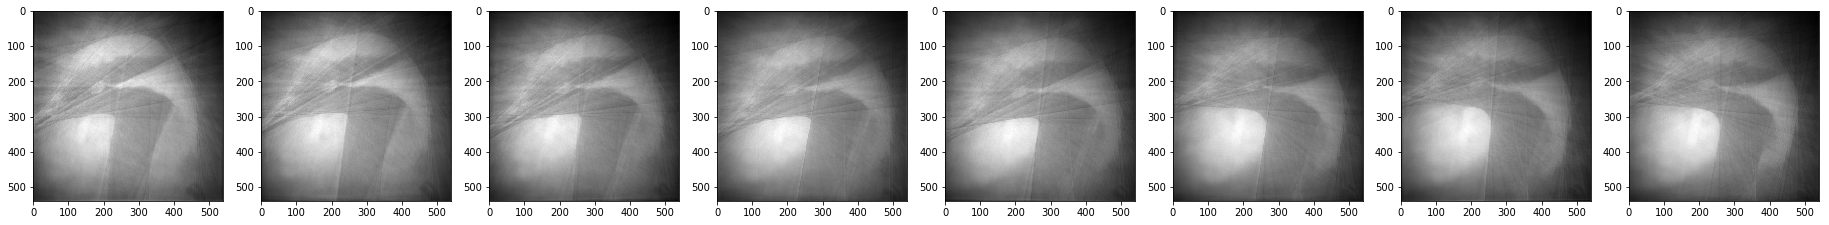

In [63]:
# Adjoint NUFFT reconstruction
plotcoil(np.abs(x_adjn_np))

In [52]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

iGRASP_recon, nufft_recon = \
RadialRecon(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (1080, 1080),
            im_size = (540, 540), 
            tolerance = 1e-5,
            lambda1 = lambda1,
            niter = 3)

iteration  0
-> 400980.6562500, 382360.5937500, L-S 22
-> 382360.5937500, 382133.7812500, L-S 8
-> 382133.7812500, 278882.7812500, L-S 3
-> 278882.7812500, 267387.2812500, L-S 0
-> 267387.2812500, 254936.3906250, L-S 3
-> 254936.3906250, 238542.0312500, L-S 2
-> 238542.0312500, 215364.3906250, L-S 2
-> 215364.3906250, 124035.2890625, L-S 1
-> 124035.2890625, 115189.3437500, L-S 1
-> 115189.3437500, 106579.3984375, L-S 2
-> 106579.3984375, 92777.6250000, L-S 0
loss= 92777.625
iteration  1
-> 92777.6250000, 23187.1328125, L-S 23
-> 23187.1328125, 22062.9335938, L-S 0
-> 22062.9335938, 20064.7910156, L-S 2
-> 20064.7910156, 10305.8681641, L-S 1
-> 10305.8681641, 6063.0180664, L-S 3
-> 6063.0180664, 3584.0820312, L-S 0
-> 3584.0820312, 2907.1125488, L-S 3
-> 2907.1125488, 1993.0456543, L-S 1
-> 1993.0456543, 1540.9792480, L-S 2
-> 1540.9792480, 1182.3619385, L-S 1
-> 1182.3619385, 821.4954224, L-S 2
loss= 821.4954223632812
iteration  2
-> 821.4954224, 594.7844238, L-S 24
-> 594.7844238, 54

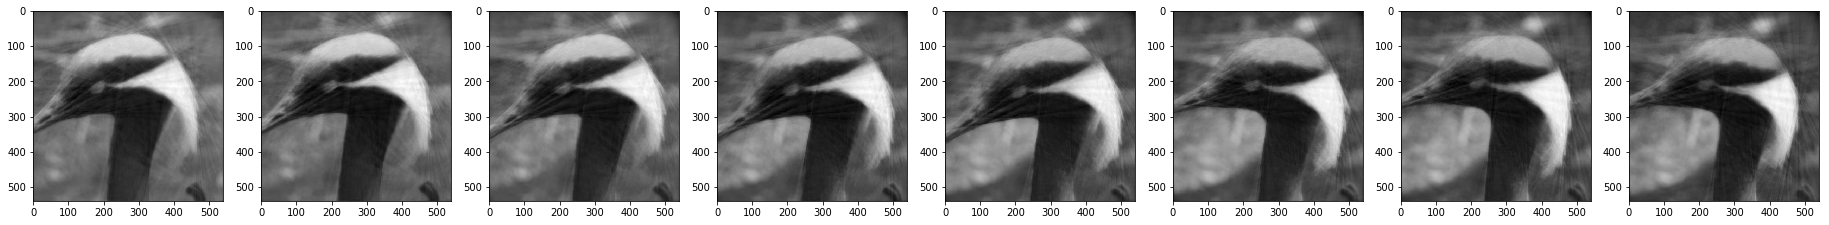

In [53]:
recon_complex = iGRASP_recon[:,0] + 1j * iGRASP_recon[:,0]

plotcoil(np.abs(recon_complex))

iteration  0
-> 400980.6562500, 382360.5937500, L-S 22
-> 382360.5937500, 382133.8125000, L-S 8
-> 382133.8125000, 278882.8125000, L-S 3
-> 278882.8125000, 267387.3437500, L-S 0
-> 267387.3437500, 254936.4375000, L-S 3
-> 254936.4375000, 238542.0781250, L-S 2
-> 238542.0781250, 215364.4531250, L-S 2
-> 215364.4531250, 124035.3281250, L-S 1
-> 124035.3281250, 115189.3515625, L-S 1
-> 115189.3515625, 106579.3984375, L-S 2
-> 106579.3984375, 92777.6015625, L-S 0
loss= 92777.6015625
iteration  1
-> 92777.6015625, 23187.1191406, L-S 23
-> 23187.1191406, 22062.8593750, L-S 0
-> 22062.8593750, 20064.6855469, L-S 2
-> 20064.6855469, 10305.7226562, L-S 1
-> 10305.7226562, 6062.9140625, L-S 3
-> 6062.9140625, 3583.9934082, L-S 0
-> 3583.9934082, 2907.0290527, L-S 3
-> 2907.0290527, 1992.9714355, L-S 1
-> 1992.9714355, 1540.9277344, L-S 2
-> 1540.9277344, 1182.3070068, L-S 1
-> 1182.3070068, 821.4517822, L-S 2
loss= 821.4517822265625
iteration  2
-> 821.4517822, 594.7427368, L-S 24
-> 594.7427368

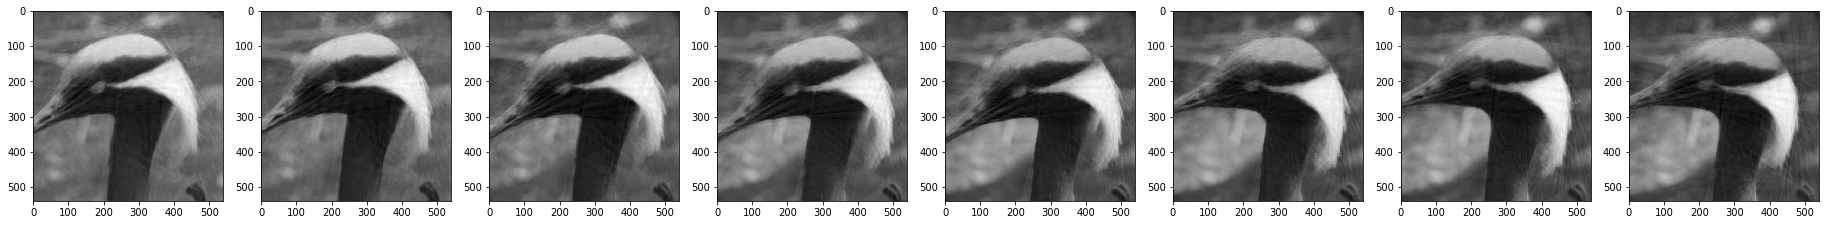

In [54]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

iGRASP_recon, nufft_recon = \
RadialRecon(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (1080, 1080),
            im_size = (540, 540), 
            tolerance = 1e-5,
            lambda1 = lambda1,
            niter = 12)

recon_complex = iGRASP_recon[:,0] + 1j * iGRASP_recon[:,0]

plotcoil(np.abs(recon_complex))

iteration  0
-> 400980.6562500, 382360.5937500, L-S 22
-> 382360.5937500, 382133.7812500, L-S 8
-> 382133.7812500, 278882.7812500, L-S 3
-> 278882.7812500, 267387.2812500, L-S 0
-> 267387.2812500, 254936.3906250, L-S 3
-> 254936.3906250, 238542.0312500, L-S 2
-> 238542.0312500, 215364.4062500, L-S 2
-> 215364.4062500, 124035.2890625, L-S 1
-> 124035.2890625, 115189.3125000, L-S 1
-> 115189.3125000, 106579.3593750, L-S 2
-> 106579.3593750, 92777.5781250, L-S 0
loss= 92777.578125
iteration  1
-> 92777.5781250, 23187.1132812, L-S 23
-> 23187.1132812, 22062.7949219, L-S 0
-> 22062.7949219, 20064.5917969, L-S 2
-> 20064.5917969, 10305.5830078, L-S 1
-> 10305.5830078, 6062.8115234, L-S 3
-> 6062.8115234, 3583.9038086, L-S 0
-> 3583.9038086, 2906.9409180, L-S 3
-> 2906.9409180, 1992.8905029, L-S 1
-> 1992.8905029, 1540.8703613, L-S 2
-> 1540.8703613, 1182.2474365, L-S 1
-> 1182.2474365, 821.4066162, L-S 2
loss= 821.4066162109375
iteration  2
-> 821.4066162, 594.7002563, L-S 24
-> 594.7002563,

-> 370.4038391, 370.3986511, L-S 3
-> 370.3986511, 370.3906555, L-S 2
-> 370.3906555, 370.3876038, L-S 2
-> 370.3876038, 370.3844604, L-S 3
-> 370.3844604, 370.3799133, L-S 2
-> 370.3799133, 370.3770752, L-S 2
-> 370.3770752, 370.3756714, L-S 2
-> 370.3756714, 370.3742981, L-S 2
-> 370.3742981, 370.3719482, L-S 2
loss= 370.3719482421875
iteration  20
-> 370.3719482, 370.3745728, L-S 30
-> 370.3745728, 370.3729553, L-S 1
-> 370.3729553, 370.3687744, L-S 1
-> 370.3687744, 370.3639221, L-S 2
-> 370.3639221, 370.3574524, L-S 2
-> 370.3574524, 370.3540344, L-S 2
-> 370.3540344, 370.3502502, L-S 3
-> 370.3502502, 370.3454895, L-S 2
-> 370.3454895, 370.3428345, L-S 2
-> 370.3428345, 370.3423767, L-S 2
-> 370.3423767, 370.3403320, L-S 3
loss= 370.34033203125
iteration  21
-> 370.3403320, 370.3550110, L-S 30
-> 370.3550110, 370.3524475, L-S 2
-> 370.3524475, 370.3445435, L-S 1
-> 370.3445435, 370.3407288, L-S 2
-> 370.3407288, 370.3352356, L-S 2
-> 370.3352356, 370.3326416, L-S 2
-> 370.3326416

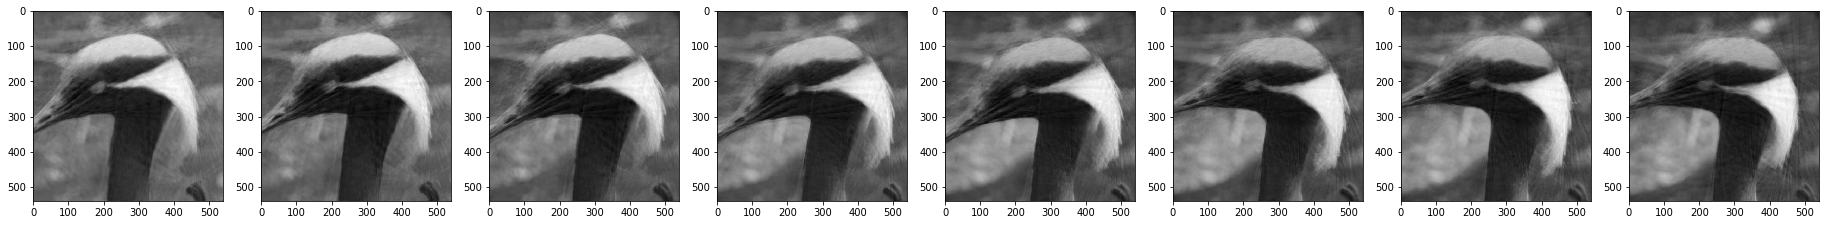

In [56]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

iGRASP_recon, nufft_recon = \
RadialRecon(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            #w = dcomp.to(device), 
            w = dcomp_trivial.to(device), 
            grid_size = (1080, 1080),
            im_size = (540, 540), 
            tolerance = 1e-10,
            lambda1 = lambda1,
            niter = 32)

recon_complex = iGRASP_recon[:,0] + 1j * iGRASP_recon[:,0]

plotcoil(np.abs(recon_complex))

## CG-SENSE reconstruction (Conjugate Gradient with NO Regularization)

coil_sensitivities.shape torch.Size([1, 16, 2, 540, 540])
0 tensor(7.4463, device='cuda:0')
0 Residual l2 norm =337.388947
1 tensor(1.9951, device='cuda:0')
1 Residual l2 norm =272.856720
2 tensor(1.5100, device='cuda:0')
2 Residual l2 norm =192.285797
3 tensor(1.6540, device='cuda:0')
3 Residual l2 norm =191.099182
4 tensor(1.0302, device='cuda:0')
4 Residual l2 norm =126.989632
5 tensor(1.3993, device='cuda:0')
5 Residual l2 norm =151.687805
6 tensor(0.8158, device='cuda:0')
6 Residual l2 norm =84.187523
7 tensor(2.1838, device='cuda:0')
7 Residual l2 norm =163.478806
8 tensor(0.5981, device='cuda:0')
8 Residual l2 norm =49.486641
9 tensor(11.6180, device='cuda:0')
9 Residual l2 norm =88.213036
10 tensor(0.4379, device='cuda:0')
10 Residual l2 norm =13.601525
11 tensor(1.3023, device='cuda:0')
11 Residual l2 norm =19.953867


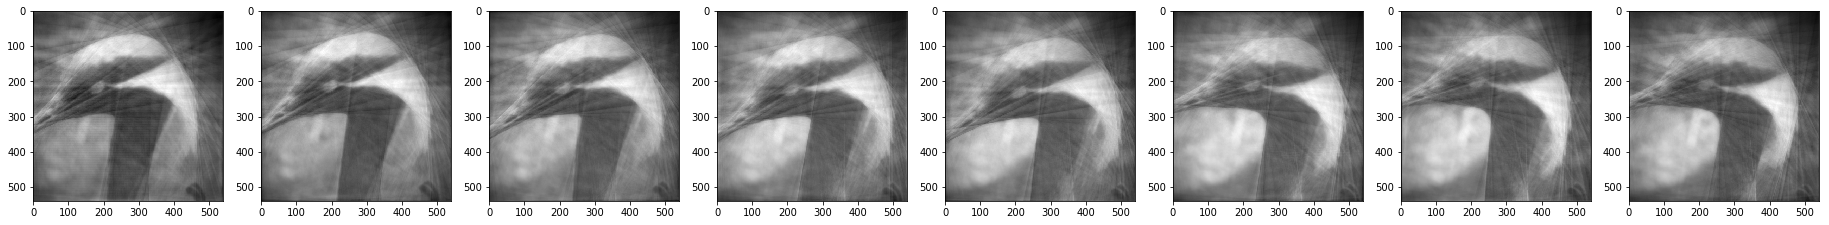

In [60]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = grid_size,
            im_size = im_size, 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 12,
            optimizer = 'CG2')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))

coil_sensitivities.shape torch.Size([1, 16, 2, 540, 540])
0 tensor(7.4463, device='cuda:0')
0 Residual l2 norm =337.388947
1 tensor(1.9951, device='cuda:0')
1 Residual l2 norm =272.856720
2 tensor(1.5100, device='cuda:0')
2 Residual l2 norm =192.285797
3 tensor(1.6540, device='cuda:0')
3 Residual l2 norm =191.099167
4 tensor(1.0302, device='cuda:0')
4 Residual l2 norm =126.989632
5 tensor(1.3993, device='cuda:0')
5 Residual l2 norm =151.687805
6 tensor(0.8158, device='cuda:0')
6 Residual l2 norm =84.187538
7 tensor(2.1838, device='cuda:0')
7 Residual l2 norm =163.478729
8 tensor(0.5981, device='cuda:0')
8 Residual l2 norm =49.486649
9 tensor(11.6179, device='cuda:0')
9 Residual l2 norm =88.214218
10 tensor(0.4379, device='cuda:0')
10 Residual l2 norm =13.601634
11 tensor(1.3023, device='cuda:0')
11 Residual l2 norm =19.953711
12 tensor(1.1102, device='cuda:0')
12 Residual l2 norm =13.753696
13 tensor(1.5858, device='cuda:0')
13 Residual l2 norm =16.821230
14 tensor(0.9629, device='cuda

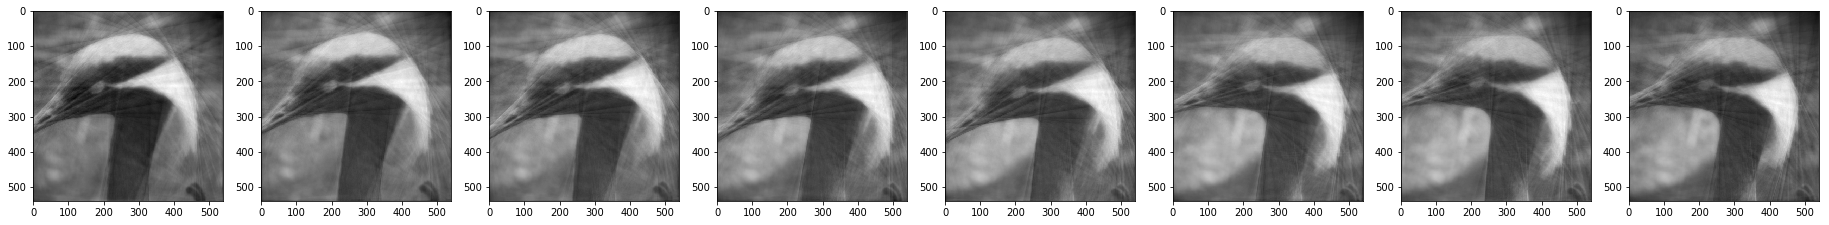

In [61]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = grid_size,
            im_size = im_size, 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG2')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))

0 alpha:  tensor([1.0419e+01, 3.4041e-07], device='cuda:0')
1 alpha:  tensor([ 1.5245e+00, -7.5244e-09], device='cuda:0')
2 alpha:  tensor([ 3.3896e+00, -1.0212e-08], device='cuda:0')
3 alpha:  tensor([2.2860e+00, 6.6442e-08], device='cuda:0')
4 alpha:  tensor([1.2886e+00, 3.2820e-08], device='cuda:0')
5 alpha:  tensor([1.4648e+00, 6.7944e-09], device='cuda:0')


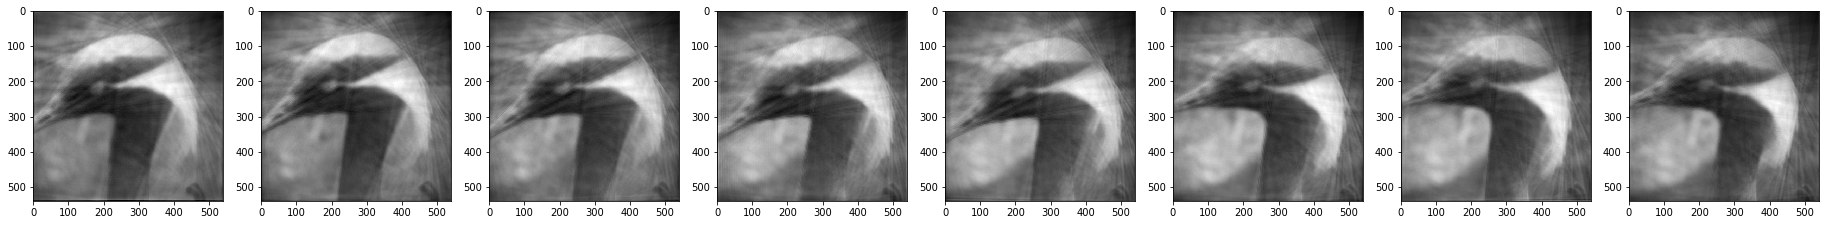

In [67]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = grid_size,
            im_size = im_size, 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 6,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))

0 alpha:  tensor([1.0419e+01, 3.3982e-07], device='cuda:0')
1 alpha:  tensor([ 1.5245e+00, -7.8534e-09], device='cuda:0')
2 alpha:  tensor([ 3.3896e+00, -9.2295e-09], device='cuda:0')
3 alpha:  tensor([2.2860e+00, 6.1570e-08], device='cuda:0')
4 alpha:  tensor([1.2886e+00, 3.6467e-08], device='cuda:0')
5 alpha:  tensor([1.4648e+00, 7.6113e-09], device='cuda:0')
6 alpha:  tensor([1.7322e+00, 2.5240e-10], device='cuda:0')
7 alpha:  tensor([ 2.1326e+00, -7.7762e-09], device='cuda:0')
8 alpha:  tensor([2.7292e+00, 2.0669e-08], device='cuda:0')
9 alpha:  tensor([2.7753e+00, 3.8152e-08], device='cuda:0')
10 alpha:  tensor([2.3144e+00, 2.6466e-08], device='cuda:0')
11 alpha:  tensor([2.0052e+00, 1.6283e-08], device='cuda:0')
12 alpha:  tensor([2.0077e+00, 8.9275e-09], device='cuda:0')
13 alpha:  tensor([ 2.2823e+00, -4.5333e-09], device='cuda:0')
14 alpha:  tensor([2.7030e+00, 1.5009e-10], device='cuda:0')
15 alpha:  tensor([2.8581e+00, 1.7651e-08], device='cuda:0')
16 alpha:  tensor([ 2.6379

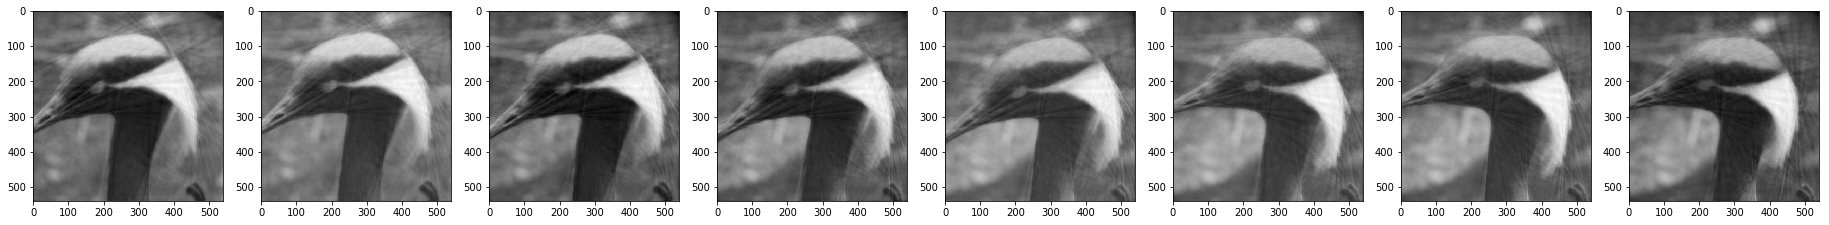

In [68]:
dcomp_trivial = torch.ones(dcomp.shape).to(device)

CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= kspace.to(device), 
            traj = traj.to(device), 
            coil_sensitivities=torch.tensor(smap[:,:,:,::4,::4], dtype = torch.float32).to(device), 
            w = dcomp.to(device), 
            #w = dcomp_trivial.to(device), 
            grid_size = grid_size,
            im_size = im_size, 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5')

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]

plotcoil(np.abs(CG_recon_complex))